In [14]:
import importlib
import ferbo as fb
importlib.reload(fb)
import numpy as np
%matplotlib widget

  0%|          | 0/100 [00:00<?, ?it/s]

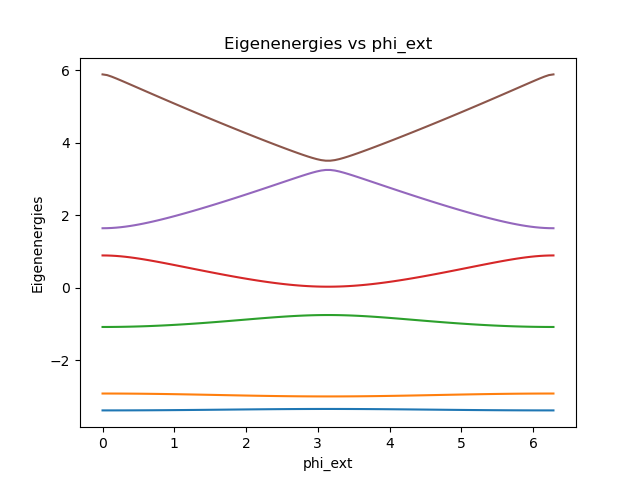

In [3]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(0, 2*np.pi, 100)

eigenenergies = fb.eigenenergies_vs_parameter('phi_ext', phi_ext_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

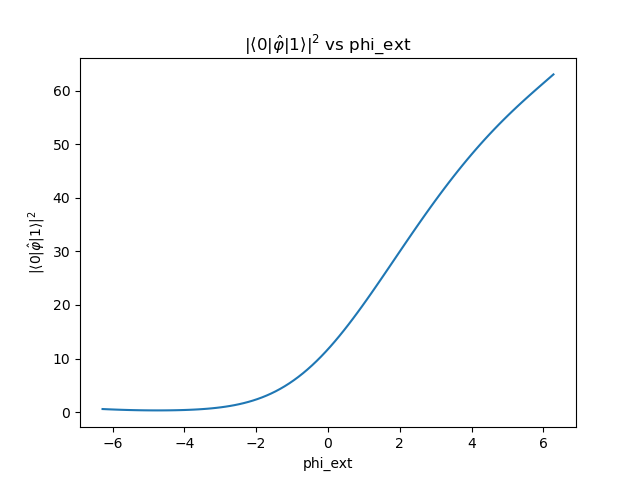

In [15]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

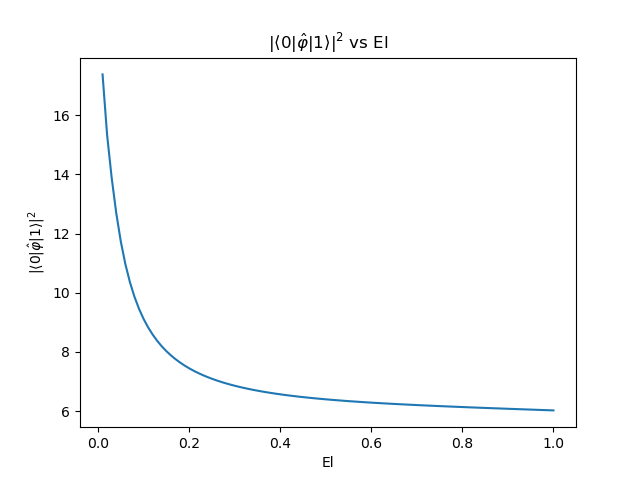

In [16]:
fixed_params = {
    'Ec': 50,
    'Delta': 20,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.linspace(0.01, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

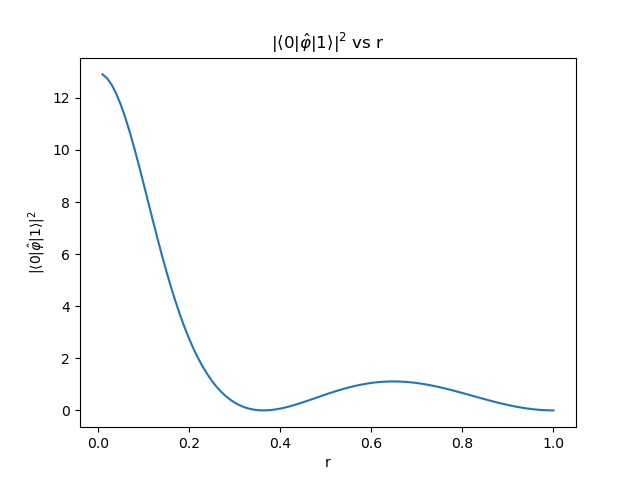

In [17]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'phi_ext': 0,
    'dimension': 100
}

r_array = np.linspace(0, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='r', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)